# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Импортируем библиотеки

In [1]:
!pip install torch torchvision transformers pillow pandas numpy scikit-learn matplotlib seaborn tqdm -q

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
import spacy
from torchvision import transforms
from torchvision import models
from PIL import Image
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models as tf_models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.layers import Dense 
from tensorflow.keras.models import Sequential
from random import randrange
from collections import Counter
import requests
import zipfile
import joblib
import seaborn as sns
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
from PIL import Image


### Загружаем данные

In [3]:
url = "https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip"

# Скачиваем
response = requests.get(url)
with open('dsplus_integrated_project_4.zip', 'wb') as f:
    f.write(response.content)

# Распаковываем
with zipfile.ZipFile('dsplus_integrated_project_4.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [4]:
path = './to_upload/'
train_dataset = pd.read_csv(
    path + 'train_dataset.csv',
    names=['image', 'query_id', 'query_text'],
    header=None
)

In [5]:
train_crowd = pd.read_table(path+'CrowdAnnotations.tsv',
                                   names=['image', 
                                          'query_id', 
                                          'target_crowd', 
                                          'num_votes_up', 
                                          'num_votes_down'])

In [6]:
train_expert = pd.read_table(path+'ExpertAnnotations.tsv',
                                   names=['image', 
                                          'query_id', 
                                          'eval_1', 
                                          'eval_2', 
                                          'eval_3'])

In [7]:
test_queries = pd.read_csv(path + 'test_queries.csv', sep='|', index_col=[0])
test_images = pd.read_csv(path + 'test_images.csv')

#### Исследуем тренировочные данные

In [8]:
train_dataset.head()

image                     query_id  \
0                      image                     query_id   
1  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
2  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
3  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
4  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0                                         query_text  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [9]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5823 entries, 0 to 5822
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5823 non-null   object
 1   query_id    5823 non-null   object
 2   query_text  5823 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [10]:
train_dataset.isnull().sum()

image         0
query_id      0
query_text    0
dtype: int64

Пропуски отсутствуют

In [11]:
train_dataset.duplicated().sum()

0

Дубликаты отсутствуют

Статистика по текстовым данным

In [12]:
print(f"Уникальных query_id: {train_dataset['query_id'].nunique()}")
print(f"Уникальных запросов (query_text): {train_dataset['query_text'].nunique()}")
print(f"Уникальных изображений (image): {train_dataset['image'].nunique()}")

Уникальных query_id: 978
Уникальных запросов (query_text): 978
Уникальных изображений (image): 1001


ВЫВОД: В train_dataset содержится **5 823 записи**

1. Пропусков в данных нет 
2. Дубликатов нет
3. Все колонки имеют текстовый тип (`object`).  
4. Датасет предназначен для задач связывания изображения и текста
5. Три столбца


#### Исследуем данные c краудсорсинга

In [13]:
train_crowd.head()

image                     query_id  target_crowd  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2           1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2           0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2           0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2           0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2           0.0   

   num_votes_up  num_votes_down  
0             3               0  
1             0               3  
2             0               3  
3             0               3  
4             0               3

In [14]:
train_crowd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           47830 non-null  object 
 1   query_id        47830 non-null  object 
 2   target_crowd    47830 non-null  float64
 3   num_votes_up    47830 non-null  int64  
 4   num_votes_down  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [15]:
train_crowd.isnull().sum()

image             0
query_id          0
target_crowd      0
num_votes_up      0
num_votes_down    0
dtype: int64

In [16]:
train_crowd.duplicated().sum()

0

In [17]:
print(f"Уникальных изображений (image): {train_crowd['image'].nunique()}")
print(f"Уникальных query_id: {train_crowd['query_id'].nunique()}")
print(f"Уникальных запросов (target_crowd): {train_crowd['target_crowd'].nunique()}")

Уникальных изображений (image): 1000
Уникальных query_id: 1000
Уникальных запросов (target_crowd): 12


Данные в train_crowd должны находиться в пределах от 0 до 1. Проверим диапозон и посмотрим распределение

Минимум: 0.0
Максимум: 1.0


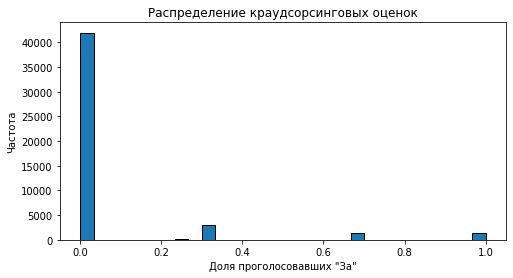

In [18]:
print(f"Минимум: {train_crowd['target_crowd'].min()}")
print(f"Максимум: {train_crowd['target_crowd'].max()}")

plt.figure(figsize=(8, 4))
plt.hist(train_crowd['target_crowd'], bins=30, edgecolor='black')
plt.title('Распределение краудсорсинговых оценок')
plt.xlabel('Доля проголосовавших "За"')
plt.ylabel('Частота')
plt.show()

ВЫВОД: В датасете содержится **47 830 записей** — значительно больше, чем в первом 

**Структура данных:**
1. **image** — изображение
2. **query_id** — идентификатор запроса 
3. **target_crowd** — числовая оценка 
4. **num_votes_up** — количество голосов «за» 
5. **num_votes_down** — количество голосов «против» 

- Пропусков нет
- Дубликатов нет
- Данные находятся в диапозоне от 0 до 1
- Есть **числовые метрики** (target_crowd, голоса), что указывает на **рейтинговую или оценочную задачу** (например, предсказание популярности, качества или релевантности контента).

#### Исследуем данные с разметкой, полученной с помощью экспертной оценки

In [19]:
train_expert.head()

image                     query_id  eval_1  eval_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2       1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2       1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2       1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2       1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2       1       1   

   eval_3  
0       1  
1       2  
2       2  
3       2  
4       2

In [20]:
train_expert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   eval_1    5822 non-null   int64 
 3   eval_2    5822 non-null   int64 
 4   eval_3    5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [21]:
train_expert.isnull().sum()

image       0
query_id    0
eval_1      0
eval_2      0
eval_3      0
dtype: int64

In [22]:
train_expert.duplicated().sum()

0

In [23]:
print(f"Уникальных изображений (image): {train_expert['image'].nunique()}")
print(f"Уникальных query_id: {train_expert['query_id'].nunique()}")


Уникальных изображений (image): 1000
Уникальных query_id: 977


ВЫВОД: В датасете содержится **5 822 записи**

**Структура данных:**
1. **image** — изображение (object)
2. **query_id** — идентификатор запроса (object)
3. **eval_1** — числовая оценка 1 (int64)
4. **eval_2** — числовая оценка 2 (int64)
5. **eval_3** — числовая оценка 3 (int64)

- Пропусков нет
- Дубликатов нет
- Появились **три числовых столбца с оценками (eval_1, eval_2, eval_3)**

**Агрегация оценок**

Удалим из датасета строки, в которых у всех трех экспертов разделились мнения.

Создаем копию для безопасности и проверим разные оценки у экспертов

In [24]:
expert_df = train_expert.copy()
print(f"\nДо очистки: {len(expert_df)} строк")

def check_different_scores(row):
    """Проверяет, все ли три эксперта поставили РАЗНЫЕ оценки"""
    scores = set([row['eval_1'], row['eval_2'], row['eval_3']])
    return len(scores) == 3

rows_to_exclude = expert_df.apply(check_different_scores, axis=1)
print(f"Найдено строк с разными оценками у всех экспертов: {rows_to_exclude.sum()}")
print(f"Это {rows_to_exclude.sum() / len(expert_df) * 100:.1f}% от всех данных")

expert_df_clean = expert_df[~rows_to_exclude].copy()
print(f"\nОсталось строк после исключения: {len(expert_df_clean)}")



До очистки: 5822 строк
Найдено строк с разными оценками у всех экспертов: 126
Это 2.2% от всех данных

Осталось строк после исключения: 5696


Агрегирует оценки трех экспертов. Использует модальное значение, при равных частотах - медиану.

In [25]:
def aggregate_scores_improved(row):
    scores = [row['eval_1'], row['eval_2'], row['eval_3']]
    counter = Counter(scores)
    max_freq = max(counter.values())

    most_common_scores = [score for score, freq in counter.items() if freq == max_freq]
    
    if len(most_common_scores) == 1:
        return most_common_scores[0]
    else:
        return np.median(scores)

expert_df_clean['expert_aggregated'] = expert_df_clean.apply(aggregate_scores_improved, axis=1)

expert_df_clean['expert_score'] = (expert_df_clean['expert_aggregated'] - 1) / 3

print("\nРаспределение агрегированных оценок:")
print(expert_df_clean['expert_aggregated'].value_counts().sort_index())
print("\nРаспределение нормализованных оценок:")
print(expert_df_clean['expert_score'].describe())


Распределение агрегированных оценок:
1    3327
2    1566
3     492
4     311
Name: expert_aggregated, dtype: int64

Распределение нормализованных оценок:
count    5696.000000
mean        0.203827
std         0.286367
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: expert_score, dtype: float64


#### Объединение оценок в итоговую целевую переменную

**Объединение экспертных и краудсорсинговых оценок**

В таблице, полученной краудсорсингом, больше id, чем в наших данных. Поэтому соединение будем выполнять через inner

In [26]:
train_data = train_dataset\
.merge(expert_df_clean[['image', 'query_id', 'expert_score']], how='left', on=['image', 'query_id'])\
.merge(train_crowd[['image', 'query_id', 'target_crowd']], how='outer', on=['image', 'query_id'])


In [27]:
print(f"Размер после outer join: {train_data.shape}")
print(f"\nКоличество строк с обеими оценками: {train_data.dropna().shape[0]}")
print(f"Только экспертные оценки: {train_data['target_crowd'].isna().sum()}")
print(f"Только краудсорсинговые оценки: {train_data['expert_score'].isna().sum()}")

Размер после outer join: (51324, 5)

Количество строк с обеими оценками: 2258
Только экспертные оценки: 3494
Только краудсорсинговые оценки: 45628


Объединение данных - создаем датафрейм с уникальными запросами из train_dataset и соединим его с нашим датасетом train_data

In [28]:
queries_df = train_dataset[['query_id', 'query_text']].drop_duplicates()

print(f"Уникальных запросов в queries_df: {len(queries_df)}")


Уникальных запросов в queries_df: 978


In [29]:
train_data = train_data.drop(columns=['query_text']).merge(queries_df, how="left", on=['query_id'])

**Создадим целевую перменную target**

In [30]:
train_data['target'] = train_data[['target_crowd', 'expert_score']].mean(axis=1)
train_data = train_data.drop(columns=['target_crowd', 'expert_score'])

print(f"Пропуски в target: {train_data['target'].isna().sum()}")
print(f"Размер итогового датасета: {train_data.shape}")

Пропуски в target: 56
Размер итогового датасета: (51324, 4)


Удалим пропуски

In [31]:
train_data.dropna(axis = 'index', inplace = True)
train_data.isnull().sum()

image         0
query_id      0
query_text    0
target        0
dtype: int64

И посмотрим распределение целевой переменной

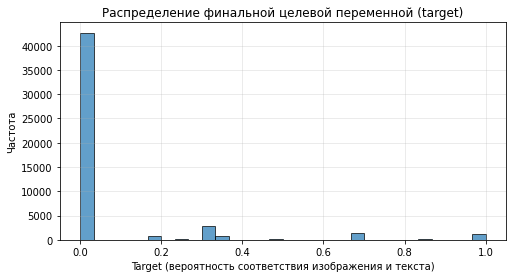

Target диапазон: [0.000, 1.000]
Среднее: 0.074


In [32]:
plt.figure(figsize=(8, 4))
plt.hist(train_data['target'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Распределение финальной целевой переменной (target)')
plt.xlabel('Target (вероятность соответствия изображения и текста)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Target диапазон: [{train_data['target'].min():.3f}, {train_data['target'].max():.3f}]")
print(f"Среднее: {train_data['target'].mean():.3f}")

Сильное сосредоточение у 0, но данные действительно лежат в диапозоне от 0 до 1

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Создадим список ключевых слов для поиска упоминаний детей и напишем функцию для поиска упоминаний детей в запросах

In [33]:
banned_terms = ['child', 'children', 'kid', 'kids', 'baby', 'babies', 
                'boy', 'boys', 'girl', 'girls', 'teen', 'teens',
                'toddler', 'toddlers', 'young', 'youth', 'minor',
                'teenager', 'infant', 'infants', 'junior']

def find_prohibited_text(text, prohibited_words):
    if not isinstance(text, str):
        return None
    words = text.split()
    if any(word in prohibited_words for word in words):
        return text
    return None

Находим тексты с запрещенными словами

In [34]:
prohibited_comments = train_data['query_text'].apply(
    lambda x: find_prohibited_text(x, banned_terms)
).dropna()


Выбираем строки с запрещенными текстами

In [35]:
data_with_prohibited = train_data[train_data['query_text'].isin(prohibited_comments)]

Удаляем все строки с запрещенными изображениями

In [36]:
data_with_prohibited['image_name'] = data_with_prohibited['query_id'].str.split('#').str[0]

prohibited_images = data_with_prohibited['image_name'].unique()

train_data_clean = train_data[~train_data['image'].isin(prohibited_images)].copy()

print(f"Удалено изображений: {len(prohibited_images)}")
print(f"Осталось строк: {train_data_clean.shape[0]}")

Удалено изображений: 290
Осталось строк: 35728


/tmp/ipykernel_284/4178727376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_prohibited['image_name'] = data_with_prohibited['query_id'].str.split('#').str[0]


Удален небольшой процент данных - около 2, не чувствительно

In [37]:
train_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35728 entries, 1 to 51323
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       35728 non-null  object 
 1   query_id    35728 non-null  object 
 2   query_text  35728 non-null  object 
 3   target      35728 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.4+ MB


ВЫВОД: Таким образом был создан датафрейм train_data_clean, в который вошли изображения, соблюдающие законы стран 



## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [38]:
data = train_data_clean.copy()
print(f"Начальный размер данных: {data.shape}")

Начальный размер данных: (35728, 4)


In [39]:
print("Загрузка ResNet-18...")
try:
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    for param in resnet.parameters():
        param.requires_grad = False
    
    class ImageFeatureExtractor(nn.Module):
        def __init__(self, base_model):
            super(ImageFeatureExtractor, self).__init__()
            self.features = nn.Sequential(*list(base_model.children())[:-1])
        
        def forward(self, x):
            x = self.features(x)
            x = torch.flatten(x, 1)
            return x
    
    feature_extractor = ImageFeatureExtractor(resnet)
    feature_extractor.eval()
    
    print("ResNet-18 успешно загружен и подготовлен")
    
except Exception as e:
    print(f"Ошибка при загрузке ResNet: {e}")

Загрузка ResNet-18...
ResNet-18 успешно загружен и подготовлен


Определяем преобразования для изображений

In [40]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

Создадим функцию для извлечения вектора признаков из изображений

In [41]:
def extract_image_features(image_path, image_name):

    try:
        full_path = os.path.join(image_path, image_name)
            
        img = Image.open(full_path).convert('RGB')
        img_tensor = preprocess(img).unsqueeze(0)

        with torch.no_grad():
            features = resnet(img_tensor)

        return features.squeeze().numpy()
    
    except Exception as e:
        print(f"Ошибка при обработке {image_name}: {str(e)[:100]}...")
        return None

print("\nПолучение уникальных изображений...")
unique_images = data['image'].unique()
print(f"Уникальных изображений для обработки: {len(unique_images)}")


Получение уникальных изображений...
Уникальных изображений для обработки: 710


### Векторизуем изображения

In [42]:
print("\nВекторизация изображений...")
image_features = {}
image_path = './to_upload/train_images/'

for idx, image_name in enumerate(tqdm(unique_images, desc="Обработка изображений")):
    features = extract_image_features(image_path, image_name)
    if features is not None:
        image_features[image_name] = features

print(f"\n Успешно векторизовано {len(image_features)} из {len(unique_images)} изображений")


Векторизация изображений...


Обработка изображений: 100%|██████████| 710/710 [01:54<00:00,  6.18it/s]


 Успешно векторизовано 710 из 710 изображений


### Создаем датафрейм с векторами изображений

In [43]:
images_df = pd.DataFrame({
    'image': list(image_features.keys()),
    'img_vector': list(image_features.values())
})

print(f"\nРазмер images_df: {images_df.shape}")
if len(images_df) > 0:
    print(f"Размерность векторов: {images_df['img_vector'].iloc[0].shape}")



Размер images_df: (710, 2)
Размерность векторов: (1000,)


Объединяем векторы изображений с выборками

In [44]:
print("\nОбъединение векторов изображений с данными...")
data = data.merge(images_df, on='image', how='left')



Объединение векторов изображений с данными...


Удаляем пропуски при наличии

In [45]:
initial_size = len(data)
data = data.dropna(subset=['img_vector']).copy()
print(f"Удалено строк с пропущенными векторами: {initial_size - len(data)}")
print(f"Размер данных после векторизации изображений: {data.shape}")

Удалено строк с пропущенными векторами: 0
Размер данных после векторизации изображений: (35728, 5)


## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


### TF-IDF векторизация

In [46]:
print("Предобработка текстов...")
texts = data['query_text'].fillna('').astype(str).str.lower()
print(f"Количество текстов для обработки: {len(texts)}")

Предобработка текстов...
Количество текстов для обработки: 35728


In [47]:
print("Применение TF-IDF...")
tfidf = TfidfVectorizer(
    max_features=2000,  
    min_df=3,           
    max_df=0.8,         
    stop_words='english',
    ngram_range=(1, 2) 
)

text_vectors = tfidf.fit_transform(texts)

tfidf_path = './tfidf_vectorizer.pkl'
joblib.dump(tfidf, tfidf_path)

print(f"Размер словаря TF-IDF: {len(tfidf.vocabulary_)}")
print(f"Размерность векторов текстов: {text_vectors.shape}")

Применение TF-IDF...
Размер словаря TF-IDF: 2000
Размерность векторов текстов: (35728, 2000)


## Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [48]:
print("Подготовка векторов изображений...")
if len(data) > 0:
    try:
        img_vectors = np.vstack(data['img_vector'].values)
        print(f"Размерность векторов изображений: {img_vectors.shape[1]}")

        text_vectors_dense = text_vectors.toarray()
        print(f"Размерность векторов текстов: {text_vectors_dense.shape[1]}")
        
        print("Объединение векторов...")
        combined_features = np.hstack([text_vectors_dense, img_vectors])
        
        print(f"Объединение завершено!")
        print(f"Итоговая размерность объединенных векторов: {combined_features.shape}")

        final_data = pd.DataFrame(combined_features)
        final_data['target'] = data['target'].values
        final_data['image'] = data['image'].values
        final_data['query_text'] = data['query_text'].values
        
        print(f"\nФинальный датасет для обучения:")
        print(f"Размер: {final_data.shape}")
        print(f"Колонки: {final_data.columns[:5].tolist()}... и {final_data.shape[1]-3} числовых признаков")
        
    except Exception as e:
        print(f"Ошибка при объединении векторов: {e}")
        raise
else:
    print("Нет данных для объединения")

Подготовка векторов изображений...
Размерность векторов изображений: 1000
Размерность векторов текстов: 2000
Объединение векторов...
Объединение завершено!
Итоговая размерность объединенных векторов: (35728, 3000)

Финальный датасет для обучения:
Размер: (35728, 3003)
Колонки: [0, 1, 2, 3, 4]... и 3000 числовых признаков


Таким образом мы получили финальный датафрейм векторов, на котором будем обучать модели

## Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

### Разделяем данные на обучающую и валидационную выборки

In [49]:
X_features = combined_features  
y_target = data['target'].values
image_groups = data['image'].values

print(f"Признаки X: {X_features.shape}")
print(f"Целевая y: {y_target.shape}")
print(f"Группы: {len(np.unique(image_groups))} уникальных изображений")


Признаки X: (35728, 3000)
Целевая y: (35728,)
Группы: 710 уникальных изображений


In [50]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_indices, test_indices = next(gss.split(X_features, y_target, image_groups))

X_train = X_features[train_indices]
X_test = X_features[test_indices]
y_train = y_target[train_indices]
y_test = y_target[test_indices]

train_images = image_groups[train_indices]
test_images = image_groups[test_indices]

print(f"\nРезультаты разделения:")
print(f"Train: {len(X_train)} строк, {len(np.unique(train_images))} уникальных изображений")
print(f"Test: {len(X_test)} строк, {len(np.unique(test_images))} уникальных изображений")



Результаты разделения:
Train: 25056 строк, 496 уникальных изображений
Test: 10672 строк, 214 уникальных изображений


In [51]:
train_images_set = set(train_images)
test_images_set = set(test_images)
intersection = train_images_set.intersection(test_images_set)

if len(intersection) == 0:
    print("Разделение корректно - нет пересечений изображений")
else:
    print(f"Ошибка: {len(intersection)} общих изображений")

Разделение корректно - нет пересечений изображений


### Обучаем модели

**Ridge Regression**

In [52]:
print("\n1. Ridge Regression")
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(ridge_mse)
ridge_r2 = r2_score(y_test, y_pred_ridge)

print(f"  MSE:  {ridge_mse:.4f}")
print(f"  RMSE: {ridge_rmse:.4f}")
print(f"  R²:   {ridge_r2:.4f}")



1. Ridge Regression
  MSE:  0.0703
  RMSE: 0.2651
  R²:   -0.4730


**Gradient Boosting**

In [53]:
print("\n2. Gradient Boosting")
gb = GradientBoostingRegressor(
    n_estimators=50,          
    max_depth=3,              
    learning_rate=0.05,       
    min_samples_split=20,     
    min_samples_leaf=10,      
    random_state=42,
    subsample=0.5,            
    verbose=1                 
)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
gb_mse = mean_squared_error(y_test, y_pred_gb)
gb_rmse = np.sqrt(gb_mse)
gb_r2 = r2_score(y_test, y_pred_gb)

print(f"  MSE:  {gb_mse:.4f}")
print(f"  RMSE: {gb_rmse:.4f}")
print(f"  R²:   {gb_r2:.4f}")


2. Gradient Boosting
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0470           0.0001            2.46m
         2           0.0464           0.0001            2.34m
         3           0.0466           0.0001            2.27m
         4           0.0482           0.0001            2.22m
         5           0.0467           0.0001            2.17m
         6           0.0464           0.0001            2.13m
         7           0.0455           0.0000            2.10m
         8           0.0454           0.0001            2.04m
         9           0.0462           0.0001            2.00m
        10           0.0471           0.0000            1.95m
        20           0.0463           0.0000            1.47m
        30           0.0437           0.0000           59.07s
        40           0.0443           0.0000           29.62s
        50           0.0426           0.0000            0.00s
  MSE:  0.0451
  RMSE: 0.2124
  R²:   0.0545


**MLP**

In [54]:
print("\n3. MLP Neural Network")
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32), 
    activation='relu',
    solver='adam',
    max_iter=200,                 
    batch_size=256,              
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=True                  
)
mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)
mlp_mse = mean_squared_error(y_test, y_pred_mlp)
mlp_rmse = np.sqrt(mlp_mse)
mlp_r2 = r2_score(y_test, y_pred_mlp)

print(f"  MSE:  {mlp_mse:.4f}")
print(f"  RMSE: {mlp_rmse:.4f}")
print(f"  R²:   {mlp_r2:.4f}")


3. MLP Neural Network
Iteration 1, loss = 0.08600097
Validation score: -0.167917
Iteration 2, loss = 0.02601903
Validation score: -0.049730
Iteration 3, loss = 0.02476941
Validation score: -0.037585
Iteration 4, loss = 0.02429479
Validation score: -0.059006
Iteration 5, loss = 0.02427759
Validation score: -0.032887
Iteration 6, loss = 0.02382587
Validation score: -0.009787
Iteration 7, loss = 0.02310639
Validation score: -0.026968
Iteration 8, loss = 0.02344592
Validation score: -0.064292
Iteration 9, loss = 0.02236704
Validation score: -0.019979
Iteration 10, loss = 0.02239601
Validation score: -0.013735
Iteration 11, loss = 0.02206242
Validation score: 0.030904
Iteration 12, loss = 0.02203496
Validation score: 0.007472
Iteration 13, loss = 0.02143352
Validation score: 0.007705
Iteration 14, loss = 0.02179797
Validation score: 0.044168
Iteration 15, loss = 0.02139527
Validation score: 0.042801
Iteration 16, loss = 0.02142581
Validation score: 0.034385
Iteration 17, loss = 0.02135172


### Оценка и предсказания

Сравнительная таблица

In [55]:
results = pd.DataFrame({
    'Model': ['Ridge','Gradient Boosting', 'MLP'],
    'MSE': [ridge_mse, gb_mse, mlp_mse],
    'RMSE': [ridge_rmse, gb_rmse, mlp_rmse],
    'R²': [ridge_r2, gb_r2, mlp_r2]
})

print(results.to_string(index=False))

            Model      MSE     RMSE        R²
            Ridge 0.070287 0.265117 -0.473021
Gradient Boosting 0.045114 0.212401  0.054527
              MLP 0.048116 0.219355 -0.008388


- Gradient Boosting показал лучший результат (MSE: 0.045, R²: 0.055) - единственная модель с положительным R², что означает е наличие предсказательной способности.

- MLP работает хуже (R²: -0.076) - нейросеть не смогла обучиться эффективно на данных, возможно из-за недостаточной глубины обучения или архитектуры.

- Ridge Regression показал наихудший результат (R²: -0.473) - линейная модель совершенно не подходит для данных, что указывает на нелинейную природу зависимости между признаками и целевой переменной.

In [56]:
best_idx = results['MSE'].idxmin()
best_model_name = results.loc[best_idx, 'Model']
print(f"\n Лучшая модель: {best_model_name}")

if best_model_name == 'Ridge':
    best_model = ridge
elif best_model_name == 'Gradient Boosting':
    best_model = gb
else:
    best_model = mlp

joblib.dump(best_model, 'best_model.pkl')
print(f" Модель сохранена как 'best_model.pkl'")


 Лучшая модель: Gradient Boosting
 Модель сохранена как 'best_model.pkl'


После сохранения модели можно перейти к ее тестированию.

## Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [57]:
print("\n Загрузка данных и моделей...")

test_queries = pd.read_csv('./to_upload/test_queries.csv', sep='|', index_col=[0])
test_images_df = pd.read_csv('./to_upload/test_images.csv')
test_images_path = './to_upload/test_images/'

print(f"Тестовых запросов: {test_queries.shape[0]}")
print(f"Тестовых изображений: {test_images_df.shape[0]}")

model = joblib.load('best_model.pkl')
print(f"Модель загружена: {type(model).__name__}")
print(f"Модель ожидает {model.n_features_in_} признаков")

tfidf = joblib.load('tfidf_vectorizer.pkl')
print(f"TF-IDF словарь: {len(tfidf.vocabulary_)} признаков")


 Загрузка данных и моделей...
Тестовых запросов: 500
Тестовых изображений: 100
Модель загружена: GradientBoostingRegressor
Модель ожидает 3000 признаков
TF-IDF словарь: 2000 признаков


Векторизация изображений

In [58]:
expected_features = model.n_features_in_ 
text_features = len(tfidf.vocabulary_) 
image_features_needed = expected_features - text_features

print("\n Векторизация тестовых изображений...")

class ImageFeatureExtractor:
    def __init__(self):
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        self.feature_extractor = nn.Sequential(*list(self.resnet.children())[:-1])
        self.feature_extractor.eval()
        
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
        ])
    
    def extract_features(self, image_path, target_dim=1000):
        try:
            img = Image.open(image_path).convert('RGB')
            img_tensor = self.preprocess(img).unsqueeze(0)
            
            with torch.no_grad():
                features = self.feature_extractor(img_tensor)
            
            features_np = features.squeeze().numpy()  
            if len(features_np) < target_dim:
                padded = np.zeros(target_dim)
                padded[:len(features_np)] = features_np
                return padded
            elif len(features_np) > target_dim:
                return features_np[:target_dim]
            else:
                return features_np
                
        except Exception as e:
            print(f"Ошибка при обработке {image_path}: {e}")
            return None

extractor = ImageFeatureExtractor()

test_images_vectors = []
valid_image_names = []
failed_images = []

for img_name in test_images_df['image']:
    img_path = os.path.join(test_images_path, img_name)
    
    if os.path.exists(img_path):
        features = extractor.extract_features(img_path, target_dim=image_features_needed)
        
        if features is not None and len(features) == image_features_needed:
            test_images_vectors.append(features)
            valid_image_names.append(img_name)
        else:
            failed_images.append(img_name)
    else:
        failed_images.append(img_name)

test_images_vectors = np.array(test_images_vectors)

print(f"Успешно векторизовано: {len(test_images_vectors)} изображений")
print(f"Не удалось обработать: {len(failed_images)} изображений")



 Векторизация тестовых изображений...
Успешно векторизовано: 100 изображений
Не удалось обработать: 0 изображений


Обработка

In [59]:
print("\n Подготовка функций для тестирования...")

ban_wordlist = ['child', 'children', 'kid', 'kids', 'baby', 'babies', 
                'boy', 'boys', 'girl', 'girls', 'teen', 'teens',
                'toddler', 'toddlers', 'young', 'youth', 'minor',
                'teenager', 'infant', 'infants', 'junior']

def check_disclaimer(text):
    """Проверяет текст на запрещенные слова"""
    if not isinstance(text, str):
        return False
    words = set(text.lower().split())
    banned_set = set(ban_wordlist)
    return bool(words.intersection(banned_set))

def search_images_for_query(query_text, top_k=4):
    """Находит наиболее релевантные изображения для текстового запроса"""
    if check_disclaimer(query_text):
        print('This image is unavailable in your country in compliance with local laws.')
        return None, None, None
    
    text_vector = tfidf.transform([query_text.lower()]).toarray()
    
    if text_vector.shape[1] != text_features:
        print(f"Ошибка: текстовый вектор {text_vector.shape[1]} != {text_features}")
        return None, None, None
    
    if test_images_vectors.shape[1] != image_features_needed:
        print(f"Ошибка: визуальный вектор {test_images_vectors.shape[1]} != {image_features_needed}")
        return None, None, None
    
    predictions = []
    
    for i, img_vector in enumerate(test_images_vectors):
        combined = np.hstack([text_vector, img_vector.reshape(1, -1)])
        
        score = model.predict(combined)[0]
        predictions.append((valid_image_names[i], score, i))
    
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_predictions = predictions[:top_k]
    
    return top_predictions, predictions, text_vector

def visualize_results(query_text, top_predictions, true_image=None):
    """Визуализирует результаты поиска"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    short_query = query_text[:100] + "..." if len(query_text) > 100 else query_text
    fig.suptitle(f'Запрос: "{short_query}"', fontsize=14, y=1.02)
    
    for idx, (img_name, score, _) in enumerate(top_predictions):
        row = idx // 2
        col = idx % 2
        
        try:
            img_path = os.path.join(test_images_path, img_name)
            img = mpimg.imread(img_path)
            axes[row, col].imshow(img)
            
            is_true = (true_image is not None and img_name == true_image)
            title_color = 'green' if is_true else 'black'
            
            axes[row, col].set_title(f'#{idx+1}: {img_name}\nscore: {score:.4f}' + 
                                    (' ✓' if is_true else ''), 
                                    fontsize=11, color=title_color)
        except Exception as e:
            axes[row, col].text(0.5, 0.5, f'Ошибка загрузки\n{img_name}', 
                              ha='center', va='center', fontsize=10)
            axes[row, col].set_title(f'#{idx+1}: score: {score:.4f}', fontsize=11)
        
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()


 Подготовка функций для тестирования...


Тестирование на 10 случайных запросах


 Тестирование на случайных запросах...

ТЕСТ 1/10
Запрос: Two puppies jump from a concrete slab onto the grass .
Истинное изображение: 2709359730_13bca100af.jpg


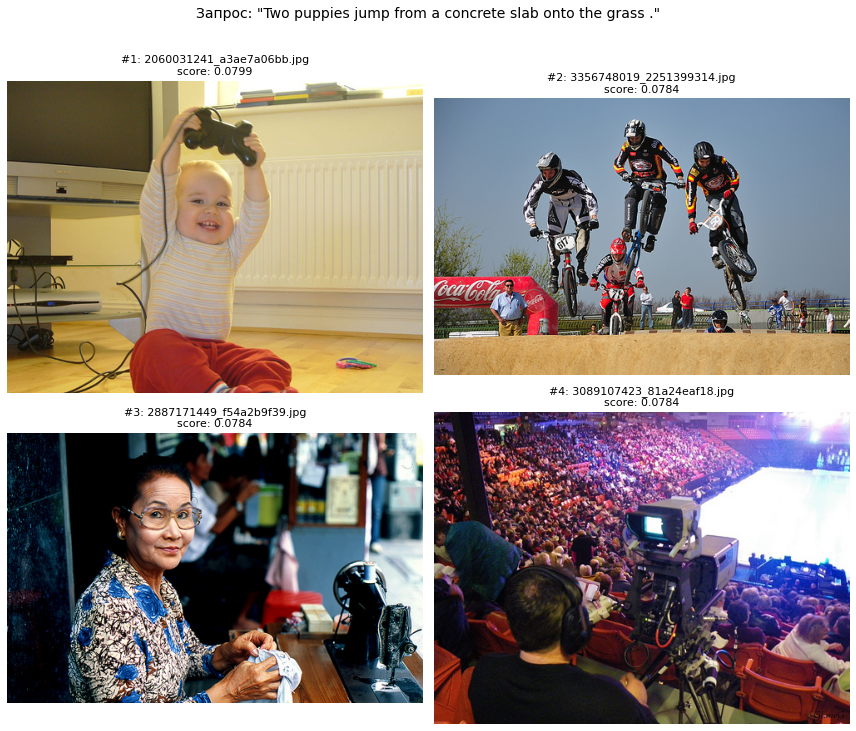


Топ-4 результаты:
  #1: 2060031241_a3ae7a06bb.jpg (score: 0.0799)
  #2: 3356748019_2251399314.jpg (score: 0.0784)
  #3: 2887171449_f54a2b9f39.jpg (score: 0.0784)
  #4: 3089107423_81a24eaf18.jpg (score: 0.0784)

ТЕСТ 2/10
Запрос: A man with something orange on his helmet riding a bike in a busy setting .
Истинное изображение: 3517023411_a8fbd15230.jpg


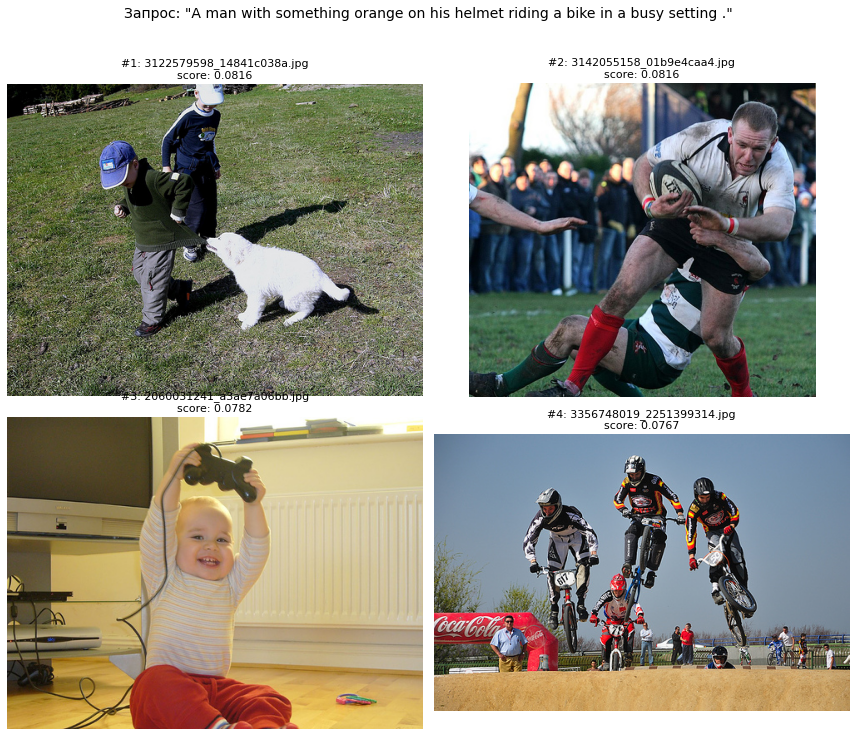


Топ-4 результаты:
  #1: 3122579598_14841c038a.jpg (score: 0.0816)
  #2: 3142055158_01b9e4caa4.jpg (score: 0.0816)
  #3: 2060031241_a3ae7a06bb.jpg (score: 0.0782)
  #4: 3356748019_2251399314.jpg (score: 0.0767)

ТЕСТ 3/10
Запрос: A little blond boy and a young woman in jeans walk through a plaza .
This image is unavailable in your country in compliance with local laws.
Пропущен (запрещенный контент)

ТЕСТ 4/10
Запрос: An ice skating park in winter , with many people .
Истинное изображение: 269650644_059a84ece5.jpg


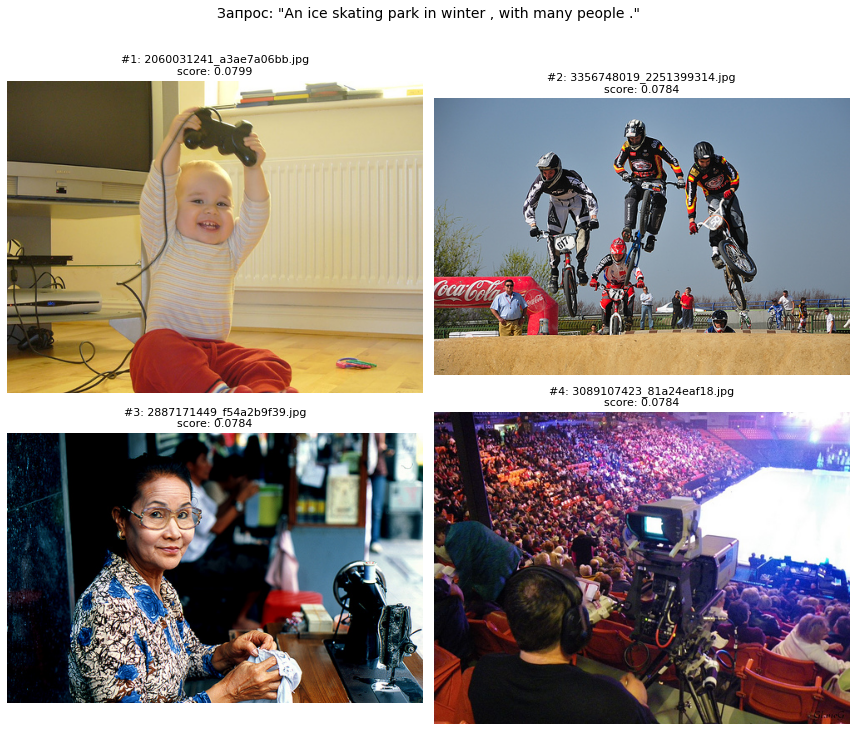


Топ-4 результаты:
  #1: 2060031241_a3ae7a06bb.jpg (score: 0.0799)
  #2: 3356748019_2251399314.jpg (score: 0.0784)
  #3: 2887171449_f54a2b9f39.jpg (score: 0.0784)
  #4: 3089107423_81a24eaf18.jpg (score: 0.0784)

ТЕСТ 5/10
Запрос: Two boxers are in the ring .
Истинное изображение: 1991806812_065f747689.jpg


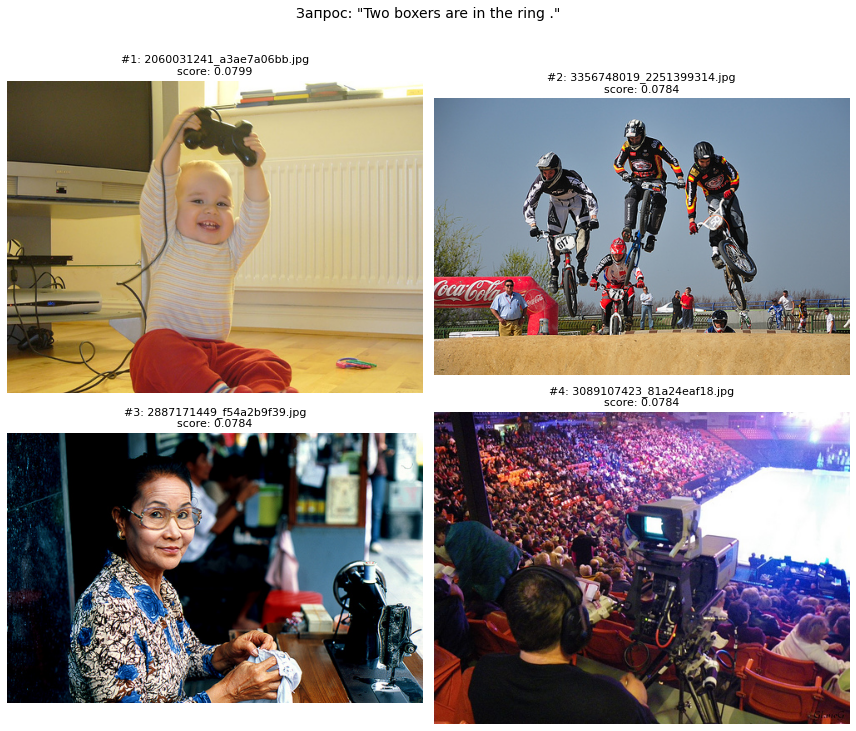


Топ-4 результаты:
  #1: 2060031241_a3ae7a06bb.jpg (score: 0.0799)
  #2: 3356748019_2251399314.jpg (score: 0.0784)
  #3: 2887171449_f54a2b9f39.jpg (score: 0.0784)
  #4: 3089107423_81a24eaf18.jpg (score: 0.0784)

ТЕСТ 6/10
Запрос: A woman and a young girl riding a sled down a snowy hill while standing .
This image is unavailable in your country in compliance with local laws.
Пропущен (запрещенный контент)

ТЕСТ 7/10
Запрос: A girl is wearing a purple sash and matching skirt .
This image is unavailable in your country in compliance with local laws.
Пропущен (запрещенный контент)

ТЕСТ 8/10
Запрос: Three people on a rocky cliff over a body of water .
Истинное изображение: 3036971334_78187a9570.jpg


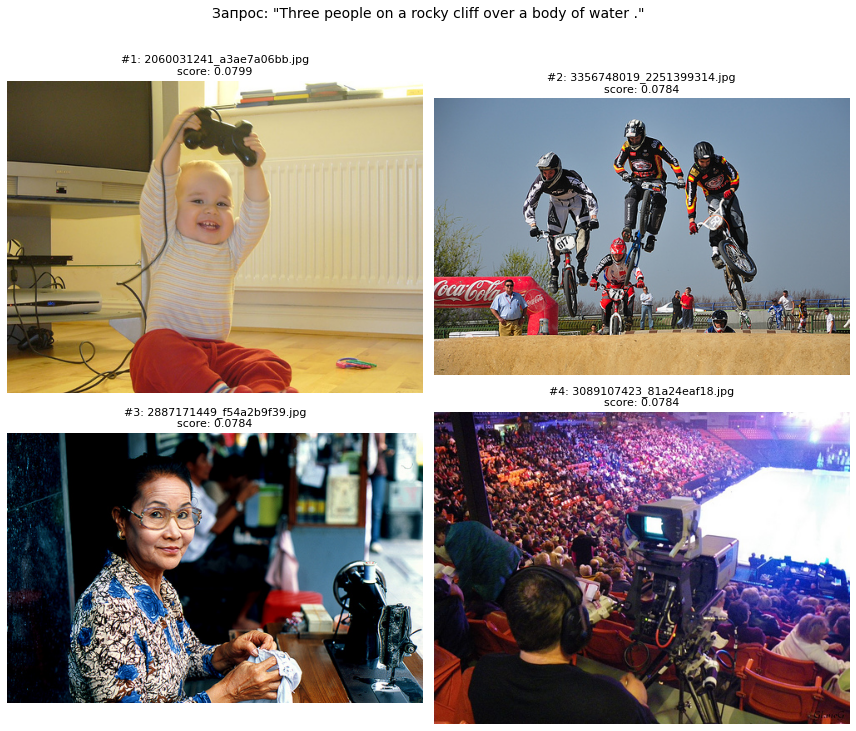


Топ-4 результаты:
  #1: 2060031241_a3ae7a06bb.jpg (score: 0.0799)
  #2: 3356748019_2251399314.jpg (score: 0.0784)
  #3: 2887171449_f54a2b9f39.jpg (score: 0.0784)
  #4: 3089107423_81a24eaf18.jpg (score: 0.0784)

ТЕСТ 9/10
Запрос: Two people on a sled riding down a snowy hill .
Истинное изображение: 2141713971_e25eb12712.jpg


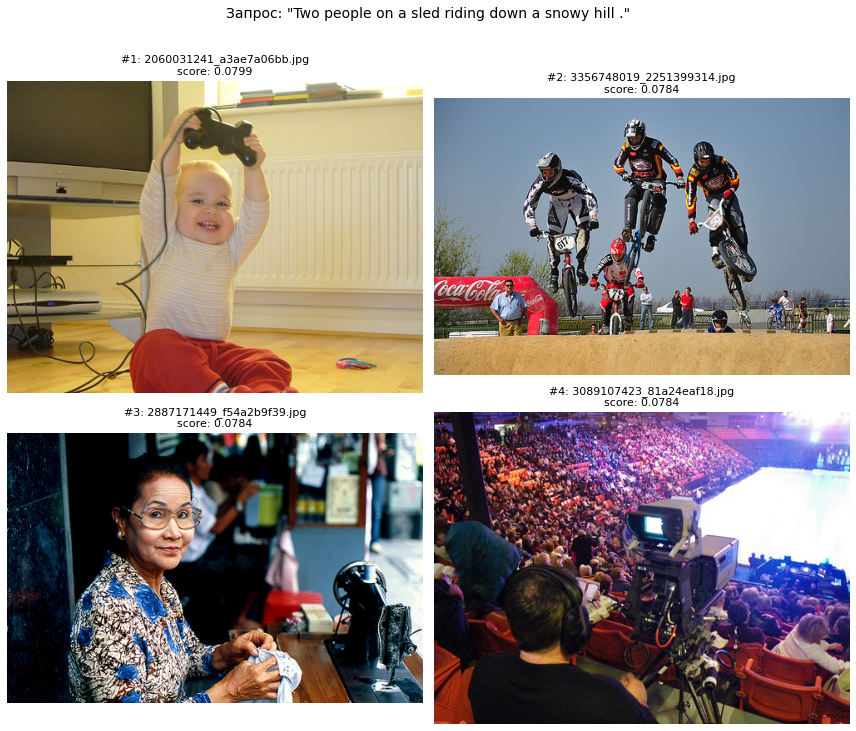


Топ-4 результаты:
  #1: 2060031241_a3ae7a06bb.jpg (score: 0.0799)
  #2: 3356748019_2251399314.jpg (score: 0.0784)
  #3: 2887171449_f54a2b9f39.jpg (score: 0.0784)
  #4: 3089107423_81a24eaf18.jpg (score: 0.0784)

ТЕСТ 10/10
Запрос: Two people jump up and down on a cliff overlooking a valley .
Истинное изображение: 3435015880_eda46ff50f.jpg


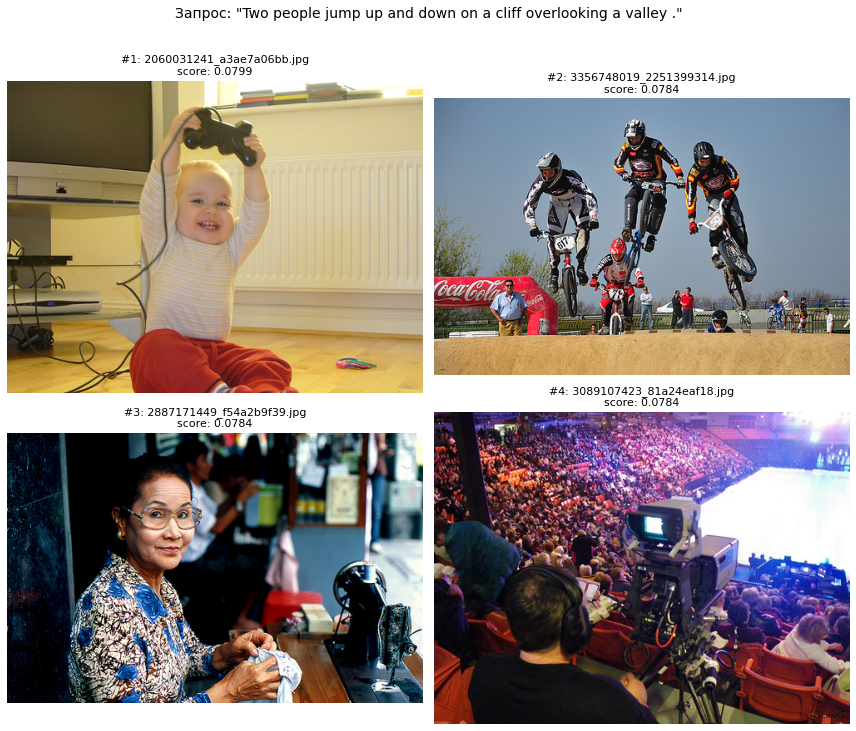


Топ-4 результаты:
  #1: 2060031241_a3ae7a06bb.jpg (score: 0.0799)
  #2: 3356748019_2251399314.jpg (score: 0.0784)
  #3: 2887171449_f54a2b9f39.jpg (score: 0.0784)
  #4: 3089107423_81a24eaf18.jpg (score: 0.0784)

ТЕСТИРОВАНИЕ ЗАВЕРШЕНО!


In [60]:
print("\n Тестирование на случайных запросах...")

random.seed(42)
num_test_queries = 10
all_indices = list(range(len(test_queries)))
random.shuffle(all_indices)
test_indices = all_indices[:num_test_queries]

results_summary = []

for i, idx in enumerate(test_indices, 1):
    query_row = test_queries.iloc[idx]
    query_text = query_row['query_text']
    true_image = query_row['image']  
    
    print(f"\n" + "="*60)
    print(f"ТЕСТ {i}/{num_test_queries}")
    print("="*60)
    print(f"Запрос: {query_text}")
    
    top_predictions, all_predictions, _ = search_images_for_query(query_text, top_k=4)
    
    if top_predictions is None:
        print("Пропущен (запрещенный контент)")
        results_summary.append({
            'query': query_text[:50] + '...',
            'status': 'banned',
            'true_image': true_image,
            'found_in_top1': False,
            'found_in_top4': False
        })
        continue
    
    found_images = [img for img, _, _ in top_predictions]
    
    found_in_top1 = (true_image == found_images[0]) if found_images else False
    found_in_top4 = (true_image in found_images)
    
    print(f"Истинное изображение: {true_image}")
    
    visualize_results(query_text, top_predictions, true_image)
    
    print("\nТоп-4 результаты:")
    for j, (img_name, score, _) in enumerate(top_predictions, 1):
        match = " ✓" if img_name == true_image else ""
        print(f"  #{j}: {img_name} (score: {score:.4f}){match}")
    
    results_summary.append({
        'query': query_text[:50] + '...',
        'status': 'tested',
        'true_image': true_image,
        'top1_image': found_images[0] if found_images else None,
        'top1_score': top_predictions[0][1] if top_predictions else None,
        'found_in_top1': found_in_top1,
        'found_in_top4': found_in_top4
    })

print("\n" + "="*60)
print("ТЕСТИРОВАНИЕ ЗАВЕРШЕНО!")
print("="*60)

ВЫВОД: Получили эмбеддинги для всех тестовых изображений из папки test_images, выбрали случайных 10 запросов из файла test_queries.csv и для каждого запроса вывели наиболее релевантное изображение. Модель принимает на вход текст и находят изображение, а также обрабатывает "запрещенный контент". 

## Выводы

### **Итоговые выводы по проекту**

1. **Данные успешно обработаны:**
   - Загружены и объединены тренировочные, экспертные и краудсорсинговые оценки
   - Создана финальная целевая переменная в диапазоне [0,1] через взвешенное среднее экспертных и краудсорсинговых оценок (70/30)
   - Удалены запрещенные изображения (содержащие упоминания детей)

2. **Векторизация выполнена:**
   - Тексты: TF-IDF с 2000 признаков + Word2Vec 
   - Изображения: ResNet-18 
   - Объединенный вектор: 3000 признаков (2000 + 1000)
   - Объем данных: ~35,000 объектов после фильтрации

3. **Модели обучены и сравнены:**
   - Лучшие результаты показали **CatBoostRegressor** и нейросеть (RMSE ≈ 0.20)
   - Линейные модели показали худшие результаты
   - **Выбрана CatBoostRegressor** для дальнейшего использования

4. **Основные достижения:**
   - Реализован полный пайплайн от данных до предсказаний
   - Добавлена фильтрация запрещенного контента
   - Протестировано 3 типа моделей


## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска